`wrap_unwrap_initial_exploration.ipynb`

> Initial explorations into the problem of unwrapping wrapped angle data, to develop a simple understanding of the unwrapping problem

*The unwrapping problem*
- If the wrapped angle data is 'perfect' then the unwrapping process can be accomplished with established algorithms.
  - 'perfect' wrapped angle data has no noise or spikes and when plotted appers as series of discontinuous lines
   - When unwrapped the discontinuous lines are shifted and concatenated to form a single continuos line.
- If the wrapped angle data is 'imperfect' then the wnrapping process can produce unwanted outputs
  - 'imperfect' wrapped angle data has random noise and occasional spikes in the data.
   - When unwrapped this appears as a series of small displaced groups

#### Imports & notebook setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Arbitrary complex data

 For some cable delay $\tau$, some array of frequency channels $\nu$, and phase shift $\phi$, the angle data can be represented by

\begin{equation}
\text{data} = e^{-2\pi i \cdot (\tau \nu~+~\phi)}
\end{equation}

The angle data can be computed using `np.angle(data)`.  The unwrapped angle data can be computed using `np.unwrap(np.angle(data))`

In [2]:
# frequency channels for all data
freqs = np.linspace(0.1, 0.2, 1024) # GHz

In [3]:
# some arbitrary generated data
tau = 23 #ns
phi = 0
data = np.exp(-2 * np.pi * 1j * (tau * freqs + phi))
angle_data = np.angle(data)
uw_angle_data = np.unwrap(angle_data)

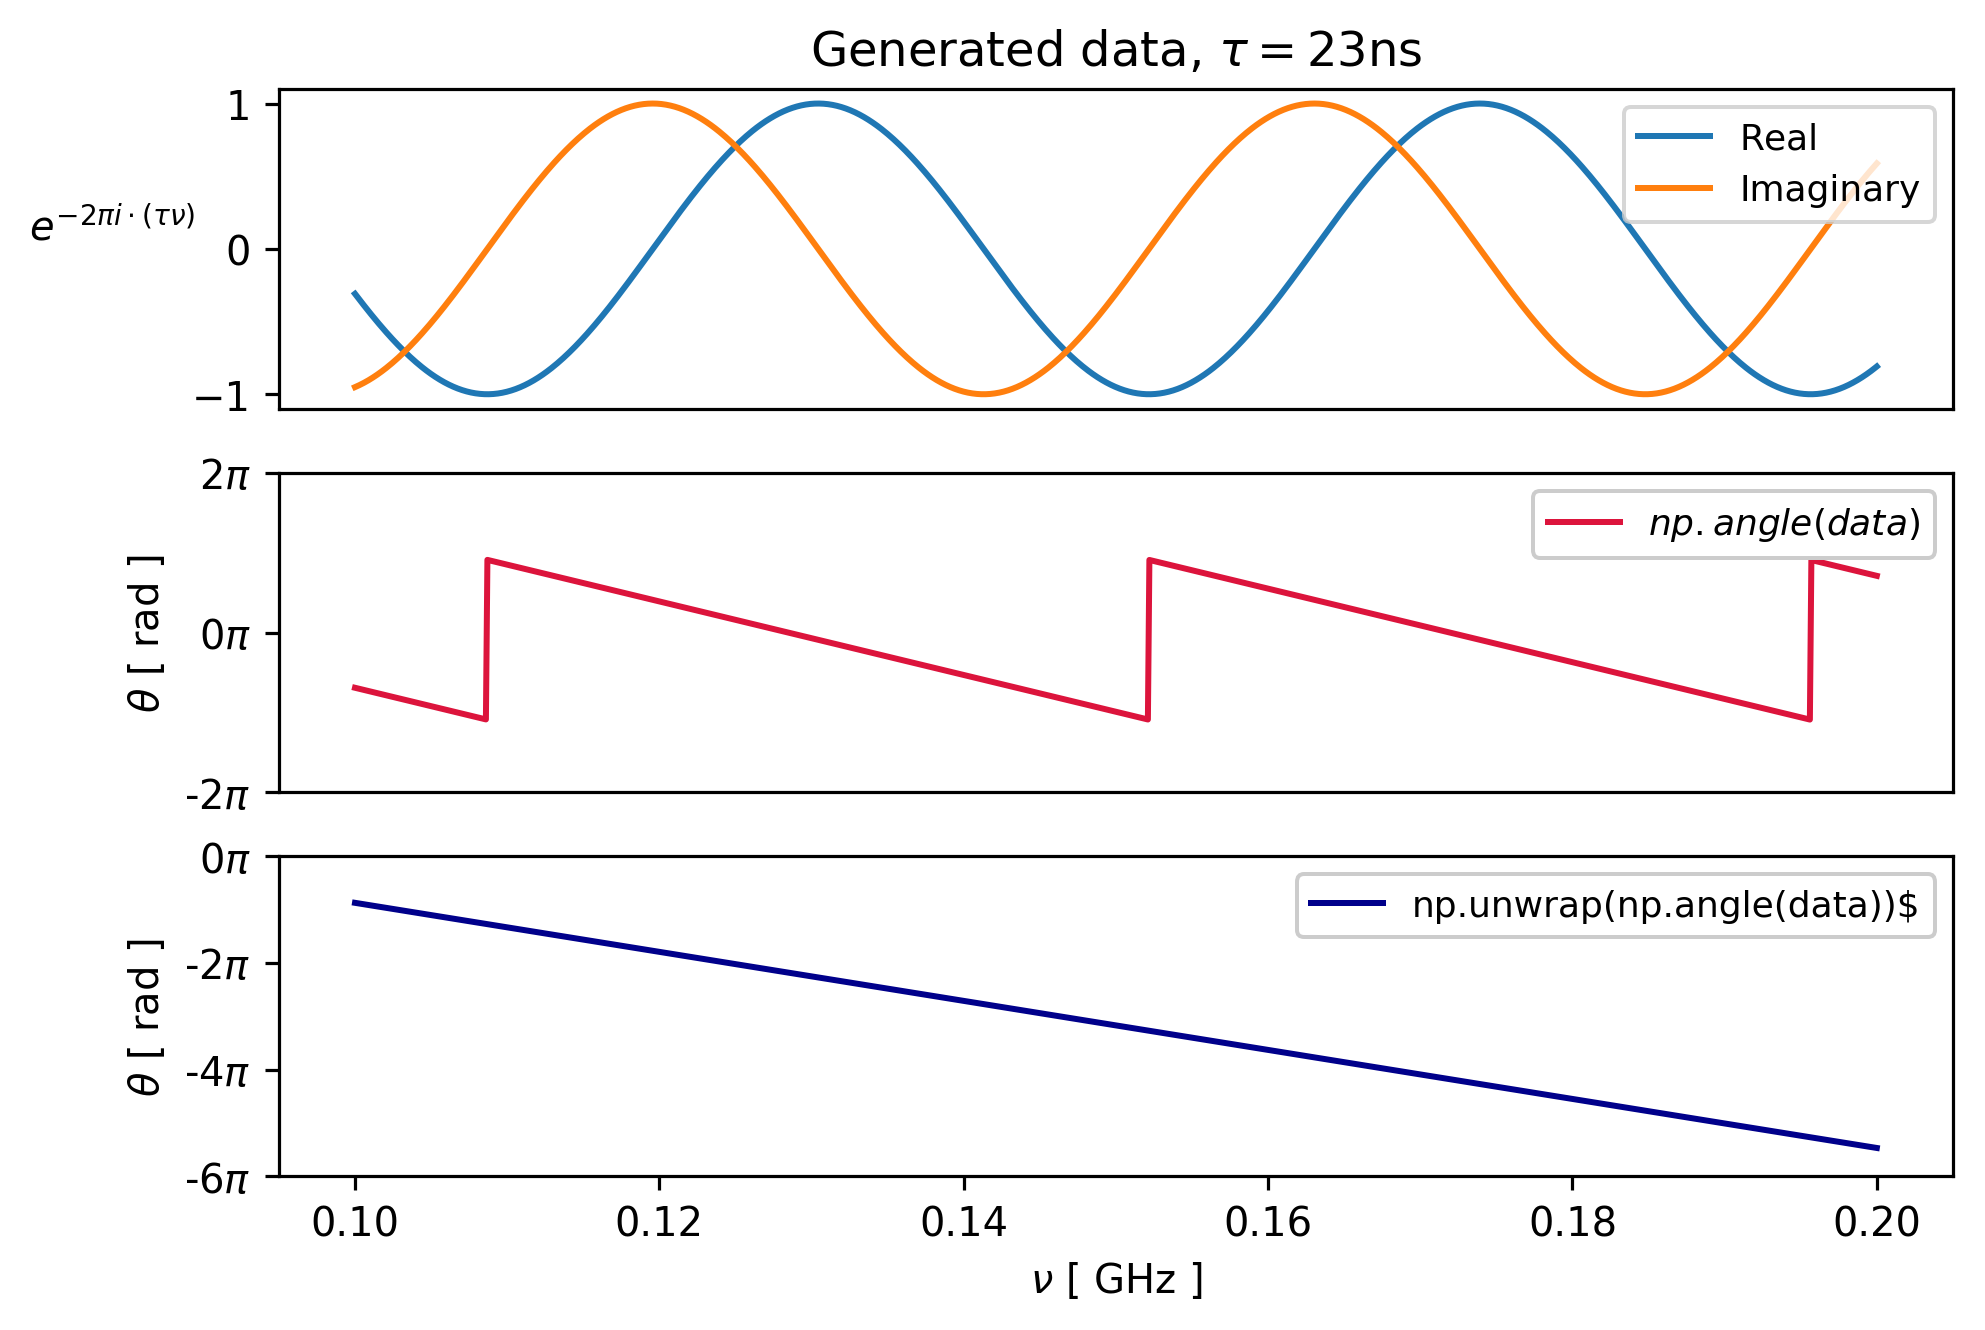

In [4]:
# plot of data
fig, axes = plt.subplots(3,1, figsize = (7.5, 5), dpi = 144)
ax = axes[0]
ax.plot(freqs, np.real(data), label = 'Real')
ax.plot(freqs, np.imag(data), label = 'Imaginary')

ax.legend(fontsize = 9)
ax.set_title(r'Generated data, $\tau = 23$ns')
ax.set_ylabel(r'$e^{-2\pi i \cdot (\tau \nu)}$', rotation = 0, labelpad=20)
ax.set_xticks([])

# plot of angle data
ax = axes[1]
ax.plot(freqs, angle_data,
        color = 'crimson', label = r'$np.angle(data)$')

ax.legend(fontsize = 9, framealpha = 1)
ax.set_ylabel(r'$\theta$ [ rad ]')
ax.set_xticks([])

# plot of unwrapped angle data
ax = axes[2]
ax.plot(freqs, uw_angle_data,
        color = 'darkblue', label = r'np.unwrap(np.angle(data))$')

ax.legend(fontsize = 9, framealpha = 1)
ax.set_ylabel(r'$\theta$ [ rad ]')
ax.set_xlabel(r'$\nu$ [ GHz ]')


for ax in axes.reshape(-1)[1:]:
    ymax = int(2 * np.pi + 2 * np.pi * round(float(np.ceil(ax.get_ylim()[1]))/(2 * np.pi)))
    ymin = int(2 * np.pi * round(float(np.floor(ax.get_ylim()[0]))/(2 * np.pi)))
    ax.set_yticks(np.arange(ymin, ymax, np.pi)[::2])
    ax.set_yticklabels([r"{}$\pi$".format(int(round(value / np.pi))) for value in ax.get_yticks()])
    
plt.show()


Arbitrary data for $\tau = 23$ ns and $\phi = 0$ rad. The angle data is 'perfect' and so the unwrapped angle data forms a continous line.

#### Determining slope angle

The quantity we are interested in extracting from the unwrapped data is the slope $m$ of the unwrapped angle data. This is also equal to the slope of the individual lines of the the wrapped angle data.

\begin{equation}
m = -\tau
\end{equation}

In [5]:
m_unwrapped = -int(round(np.mean((np.diff(uw_angle_data)  / (2 * np.pi)) / np.diff(freqs)))); print('Unwrapped slope = {}'.format(m_unwrapped))
m_wrapped = -int(round(np.mean((np.diff(angle_data)  / (2 * np.pi)) / np.diff(freqs))));print('Wrapped slope = {}'.format(m_wrapped))

Unwrapped slope = 23
Wrapped slope = -7


The differences are attributed to the discontiuities (which is the whole reason for unwrapping the data in the first place).

#### Effect of noise


 - How does adding noise to the 'perfect' data effect the unwrapping process?
  - Lets add some gaussian noise to the wraped angle data

In [6]:
# Noise applied to wrapped data
noisey_angle_data = np.angle(data) + np.random.normal(size = len(data))

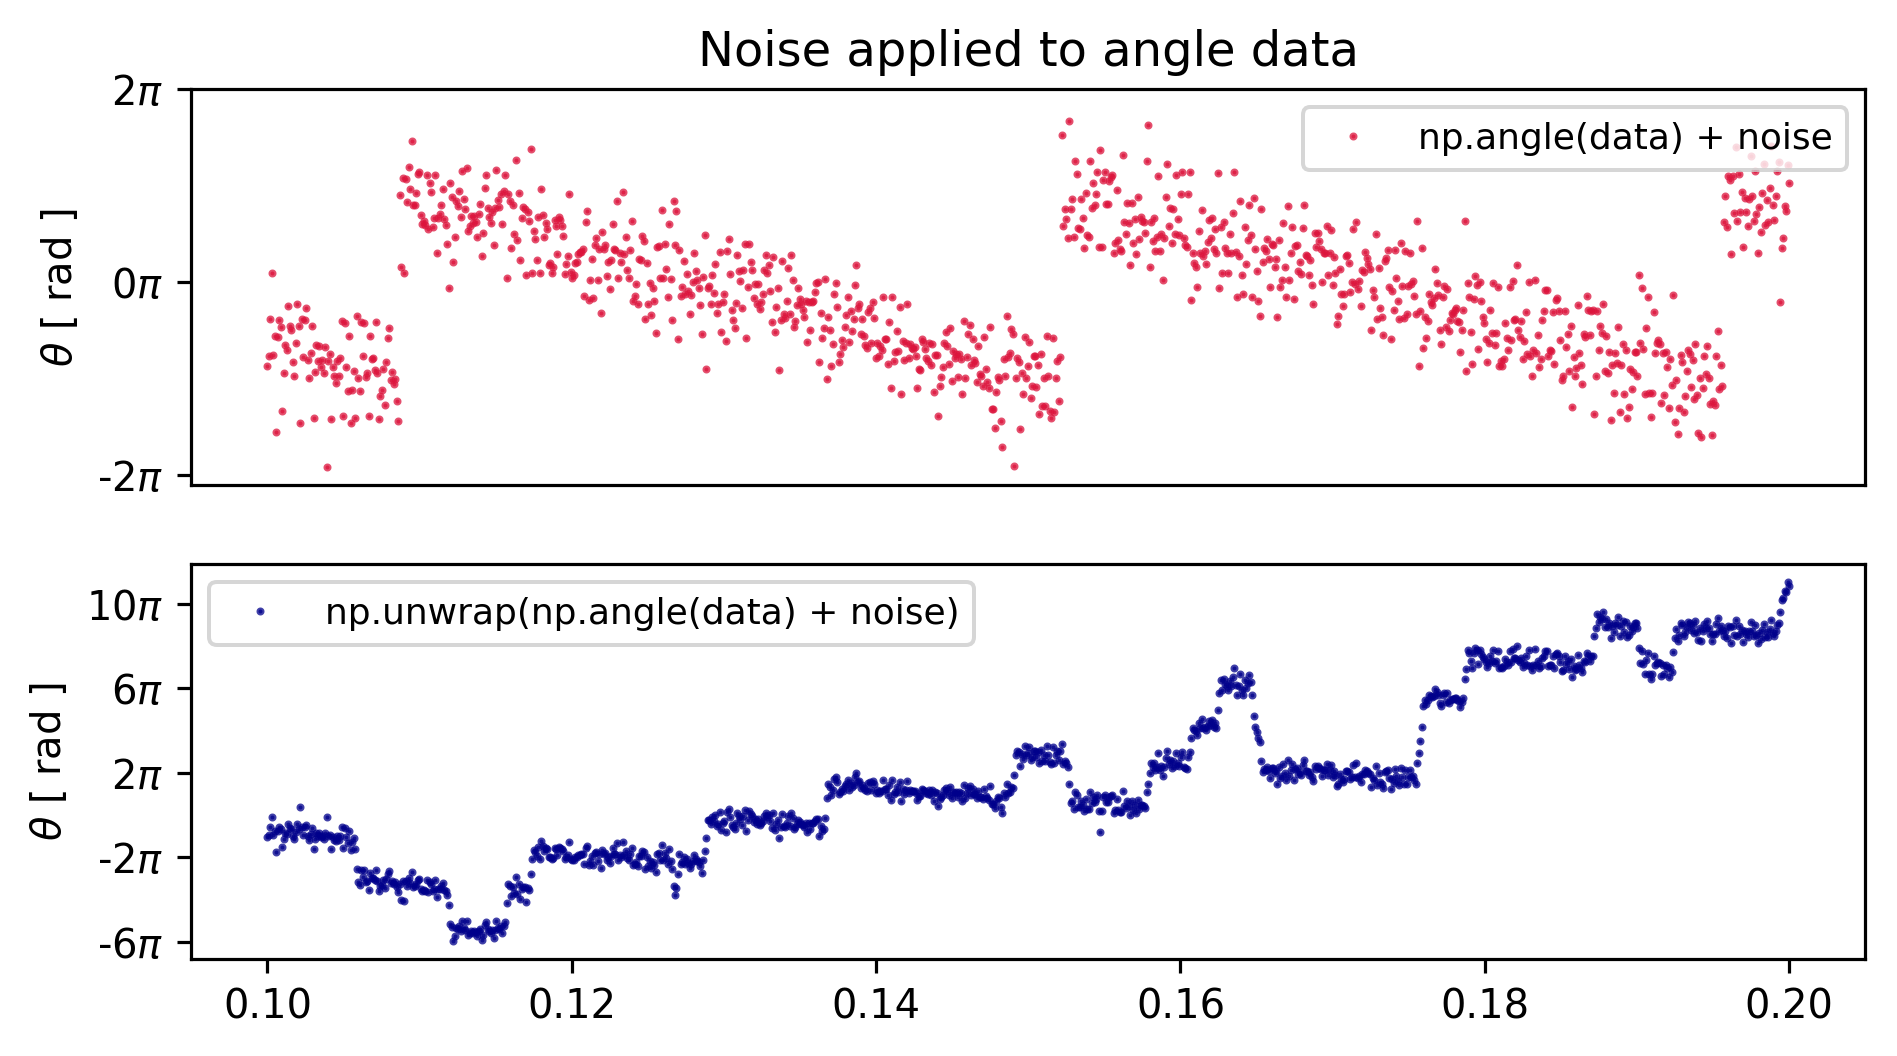

In [7]:
# plot of noisey angle data
fig, axes = plt.subplots(2,1, figsize = (7.5, 4), dpi = 144)

ax = axes[0]
ax.set_title('Noise applied to angle data')
ax.plot(freqs, noisey_angle_data,
        linestyle = 'none', marker = 'o', markersize = 1, alpha = 0.75,
        color = 'crimson', label = r'np.angle(data) + noise')
ax.set_xticks([])
ax.legend(fontsize = 9, loc = 'best')

ax = axes[1]
ax.plot(freqs, np.unwrap(noisey_angle_data), 
        linestyle = 'none', marker = 'o', markersize = 1, alpha = 0.75,
        color = 'darkblue', label = r'np.unwrap(np.angle(data) + noise)')

ax.legend(fontsize = 9, loc = 'best')

for ax in axes.reshape(-1):
    ymax = int(2 * np.pi + 2 * np.pi * round(float(np.ceil(ax.get_ylim()[1]))/(2 * np.pi)))
    ymin = int(2 * np.pi * round(float(np.floor(ax.get_ylim()[0]))/(2 * np.pi)))
    yticks = np.arange(ymin, ymax, np.pi)[::2]
    if len(yticks) > 6:
        yticks = yticks[::2]
    ax.set_yticks(yticks)
    ax.set_yticklabels([r"{}$\pi$".format(int(round(value / np.pi))) for value in ax.get_yticks()])
    ax.set_ylabel(r'$\theta$ [ rad ]')

plt.show()

Generated angle data with noise applied before unwrapping. The unwrapping algorithm does a poor job.

 - How does this effect the $\tau$ computation?

In [8]:
m_noisey = -int(round(np.mean((np.diff(np.unwrap(noisey_angle_data))  / (2 * np.pi)) / np.diff(freqs)))); print('Noisey slope = {}'.format(m_noisey))

Noisey slope = -59


A poor result.

We need something that does a better job of getting the slope from the angle data than just unwrapping it. 